In [1]:
import datetime as dt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
dirname0 = "realTraffic/realTraffic/"
filename0 = "TravelTime_387.csv"
dataframe = pd.read_csv(dirname0+filename0)#, usecols=[1])#, skipfooter=3)
dataframe.head()

,timestamp,value
0,2015-07-10 14:24:00,564
1,2015-07-10 14:38:00,730
2,2015-07-10 14:48:00,770
3,2015-07-10 15:03:00,910
4,2015-07-10 15:22:00,1035


In [3]:
def remap(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

dataframe['prop_value'] = remap( dataframe.value.values, np.min (dataframe.value), np.max( dataframe.value), 0.0, 100.0  )
dataframe.head()

,timestamp,value,prop_value
0,2015-07-10 14:24:00,564,10.990099
1,2015-07-10 14:38:00,730,14.277228
2,2015-07-10 14:48:00,770,15.069307
3,2015-07-10 15:03:00,910,17.841584
4,2015-07-10 15:22:00,1035,20.316832


In [5]:
from pyod.models.ocsvm import OCSVM   #PyOD is a comprehensive and scalable Python toolkit for detecting outlier objects

random_state = np.random.RandomState(42)     # A fixed values is assigned, then no matter how many time you execute your code,values generated would be the same
#Does this mean that later on the code the outliers 5% higher than maximum value of dataset?
outliers_fraction = 0.05
classifiers = {
        'One Classify SVM (SVM)':OCSVM(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, nu=0.5, shrinking=True, cache_size=200, verbose=False, max_iter=-1, contamination=outliers_fraction)
}

In [6]:
X = dataframe['value'].values.reshape(-1,1)

In [7]:
from scipy import stats
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    
    # copy of dataframe
    dfx = dataframe[['value','prop_value']]
    dfx['outlier'] = y_pred.tolist()
    IX1 =  np.array(dfx['value'][dfx['outlier'] == 0]).reshape(-1,1)
    OX1 =  dfx['value'][dfx['outlier'] == 1].values.reshape(-1,1)         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
y = dfx['outlier'].values.reshape(-1,1)

OUTLIERS :  125 INLIERS :  2375 One Classify SVM (SVM)


In [8]:
tOut = stats.scoreatpercentile(dfx[dfx['outlier'] == 1]['value'], np.abs(threshold))

In [9]:
def severity_validation():
    tOUT10 = tOut+(tOut*0.10)    
    tOUT23 = tOut+(tOut*0.23)
    tOUT45 = tOut+(tOut*0.45)
    dfx['test_severity'] = "None"
    for i, row in dfx.iterrows():
        if row['outlier']==1:
            if row['value'] <=tOUT10:
                dfx['test_severity'][i] = "Low Severity" 
            elif row['value'] <=tOUT23:
                dfx['test_severity'][i] = "Medium Severity" 
            elif row['value'] <=tOUT45:
                dfx['test_severity'][i] = "High Severity" 
            else:
                dfx['test_severity'][i] = "Ultra High Severity" 

severity_validation()

In [10]:
dfx.head()

,value,prop_value,outlier,test_severity
0,564,10.990099,0,None
1,730,14.277228,0,None
2,770,15.069307,1,Ultra High Severity
3,910,17.841584,0,None
4,1035,20.316832,0,None


### Mean Proportion of Outlier Values

In [11]:
print(" inline values proportion mean ",dfx[dfx['outlier']==0]['prop_value'].mean())
print(" outlier values proportion mean",dfx[dfx['outlier']==1]['prop_value'].mean())
print(" outlier values max ",dfx[dfx['outlier']==1]['prop_value'].min())



 inline values proportion mean  5.03875768629494
 outlier values proportion mean 29.44918811881187
 outlier values max  0.2376237623762376


Values com proportion more than 0.2376237623762376% are bad.



### TimeSeries

In [12]:
dirname = "realTraffic/realTraffic/"
filename = "speed_t4013.csv"

dataframe = pd.read_csv(dirname+filename)#, usecols=[1])#, skipfooter=3)
dataframe.head()


,timestamp,value
0,2015-09-01 11:25:00,58
1,2015-09-01 11:30:00,63
2,2015-09-01 11:35:00,63
3,2015-09-01 11:40:00,64
4,2015-09-01 11:55:00,58


In [13]:
# Any results you write to the current directory are saved as output.
for dirname, _, filenames in os.walk('realKnownCause/realKnownCause/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

realKnownCause/realKnownCause/ambient_temperature_system_failure.csv
realKnownCause/realKnownCause/machine_temperature_system_failure.csv
realKnownCause/realKnownCause/ec2_request_latency_system_failure.csv
realKnownCause/realKnownCause/rogue_agent_key_updown.csv
realKnownCause/realKnownCause/nyc_taxi.csv
realKnownCause/realKnownCause/cpu_utilization_asg_misconfiguration.csv
realKnownCause/realKnownCause/rogue_agent_key_hold.csv


In [14]:
for dirname, _, filenames in os.walk('realAdExchange/realAdExchange/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


realAdExchange/realAdExchange/exchange-3_cpm_results.csv
realAdExchange/realAdExchange/exchange-4_cpm_results.csv
realAdExchange/realAdExchange/exchange-2_cpm_results.csv
realAdExchange/realAdExchange/exchange-2_cpc_results.csv
realAdExchange/realAdExchange/exchange-4_cpc_results.csv
realAdExchange/realAdExchange/exchange-3_cpc_results.csv


In [15]:
# Any results you write to the current directory are saved as output.
import os
for dirname, _, filenames in os.walk('realAWSCloudwatch/realAWSCloudwatch/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv
realAWSCloudwatch/realAWSCloudwatch/ec2_network_in_257a54.csv
realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_c6585a.csv
realAWSCloudwatch/realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv
realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv
realAWSCloudwatch/realAWSCloudwatch/ec2_disk_write_bytes_c0d644.csv
realAWSCloudwatch/realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv
realAWSCloudwatch/realAWSCloudwatch/ec2_network_in_5abac7.csv
realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_ac20cd.csv
realAWSCloudwatch/realAWSCloudwatch/elb_request_count_8c0756.csv
realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv
realAWSCloudwatch/realAWSCloudwatch/ec2_disk_write_bytes_1ef3de.csv
realAWSCloudwatch/realAWSCloudwatch/iio_us-east-1_i-a2eb1cd9_NetworkIn.csv
realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv
realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_77c1ca.c

In [17]:
df1 = pd.read_csv('realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv')
df2 = pd.read_csv('realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_ac20cd.csv')
df3 = pd.read_csv('realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_fe7f93.csv')
df4 = pd.read_csv('realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_77c1ca.csv')
df5 = pd.read_csv('realAWSCloudwatch/realAWSCloudwatch/ec2_network_in_5abac7.csv')
df6 = pd.read_csv('realAWSCloudwatch/realAWSCloudwatch/grok_asg_anomaly.csv')
df7 = pd.read_csv('realAWSCloudwatch/realAWSCloudwatch/elb_request_count_8c0756.csv')
df8 = pd.read_csv('realAdExchange/realAdExchange/exchange-2_cpc_results.csv')


In [22]:
df1.head()

,timestamp,value
0,2014-04-10 00:04:00,91.958
1,2014-04-10 00:09:00,94.798
2,2014-04-10 00:14:00,92.208
3,2014-04-10 00:19:00,93.722
4,2014-04-10 00:24:00,93.042


In [23]:
df2.head()

,timestamp,value
0,2014-04-02 14:29:00,42.652
1,2014-04-02 14:34:00,41.362
2,2014-04-02 14:39:00,43.408
3,2014-04-02 14:44:00,40.262
4,2014-04-02 14:49:00,40.328


In [24]:
df3.head()

,timestamp,value
0,2014-02-14 14:27:00,2.296
1,2014-02-14 14:32:00,2.144
2,2014-02-14 14:37:00,2.274
3,2014-02-14 14:42:00,2.066
4,2014-02-14 14:47:00,2.350


In [25]:
df4.head()

,timestamp,value
0,2014-04-02 14:25:00,0.068
1,2014-04-02 14:30:00,0.102
2,2014-04-02 14:35:00,0.100
3,2014-04-02 14:40:00,0.098
4,2014-04-02 14:45:00,0.102


In [26]:
df5.head()

,timestamp,value
0,2014-03-01 17:36:00,42.0
1,2014-03-01 17:41:00,94.8
2,2014-03-01 17:46:00,42.0
3,2014-03-01 17:51:00,68.4
4,2014-03-01 17:56:00,68.4


In [27]:
df6.head()

,timestamp,value
0,2014-01-16 00:00:00,33.5573
1,2014-01-16 00:05:00,33.4460
2,2014-01-16 00:10:00,33.4447
3,2014-01-16 00:15:00,33.3333
4,2014-01-16 00:20:00,33.4447


In [28]:
df7.head()

,timestamp,value
0,2014-04-10 00:04:00,94.0
1,2014-04-10 00:09:00,56.0
2,2014-04-10 00:14:00,187.0
3,2014-04-10 00:19:00,95.0
4,2014-04-10 00:24:00,51.0


In [29]:
df8.head()

,timestamp,value
0,2011-07-01 00:00:01,0.081965
1,2011-07-01 01:00:01,0.098972
2,2011-07-01 02:00:01,0.065314
3,2011-07-01 03:00:01,0.070663
4,2011-07-01 04:00:01,0.102490


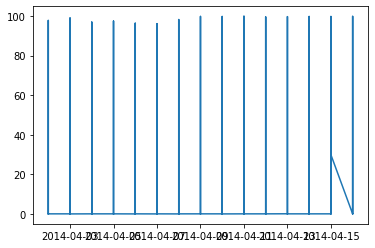

In [30]:
x = [dt.datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in df4["timestamp"]]
y = df4["value"]

plt.plot(x,y)
plt.show()

In [31]:
fpath = "realAWSCloudwatch/realAWSCloudwatch//"
fname = "grok_asg_anomaly.csv"

fullPath = fpath + fname

def parser(x):
	return dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
 
data = pd.read_csv(fullPath, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

### ARIMA

In [32]:
arimaM = ARIMA(data, order=(5,1,0))
arimaMfit = arimaM.fit(disp=0)
print(arimaMfit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                 4620
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -9374.324
Method:                       css-mle   S.D. of innovations              1.841
Date:                Mon, 06 Apr 2020   AIC                          18762.648
Time:                        14:19:11   BIC                          18807.715
Sample:                    01-16-2014   HQIC                         18778.507
                         - 02-01-2014                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0072      0.012     -0.612      0.541      -0.030       0.016
ar.L1.D.value    -0.4859      0.015    -33.136      0.000      -0.515      -0.457
ar.L2.D.value    -0.3361      0.016    -

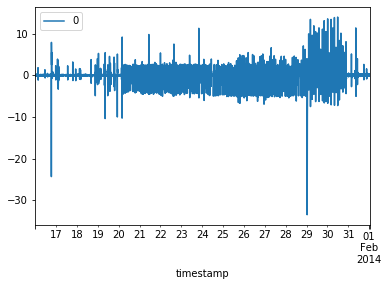

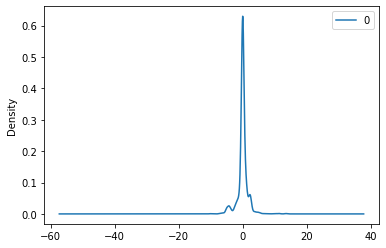

                 0
count  4620.000000
mean     -0.000024
std       1.840801
min     -33.508569
25%      -0.219106
50%       0.025824
75%       0.336734
max      14.011793


In [33]:
# plot residual errors
errors = pd.DataFrame(arimaMfit.resid)
errors.plot()
pyplot.show()
errors.plot(kind='kde')
pyplot.show()
print(errors.describe())


In [34]:
X = data.values
size = int(len(X) * 0.70)
limitCount = 50
train, test = X[0:size], X[size:size+limitCount]
history = [x for x in train]

In [35]:
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('pred=%f, exp=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Mean Squared Error: %.3f' % error)

pred=33.460519, exp=33.333300
pred=33.372460, exp=33.554000
pred=33.477429, exp=36.071400
pred=34.536293, exp=39.381400
pred=36.293244, exp=36.309300
pred=35.695997, exp=35.714300
pred=35.733881, exp=35.950700
pred=36.375207, exp=35.714300
pred=36.160727, exp=35.952900
pred=36.251577, exp=35.714300
pred=35.857497, exp=30.895400
pred=33.731914, exp=33.472500
pred=34.155082, exp=33.333300
pred=34.071444, exp=33.333300
pred=33.304605, exp=33.444700
pred=33.478240, exp=33.442700
pred=33.156076, exp=33.444700
pred=33.417751, exp=33.446000
pred=33.425870, exp=33.442700
pred=33.432279, exp=33.442700
pred=33.443503, exp=33.444700
pred=33.444295, exp=33.442700
pred=33.443401, exp=33.333300
pred=33.397320, exp=40.005000
pred=36.176089, exp=36.787900
pred=35.782865, exp=35.950700
pred=35.421512, exp=35.714300
pred=36.259953, exp=35.954300
pred=36.101225, exp=35.714300
pred=36.310072, exp=35.714300
pred=35.859201, exp=35.952900
pred=35.886796, exp=35.948600
pred=35.865663, exp=35.714300
pred=35.79

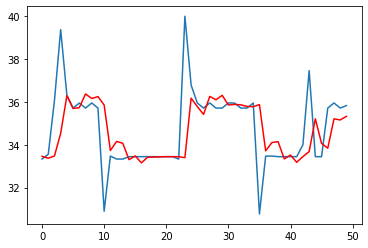

In [36]:
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### Keras Models

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


Using TensorFlow backend.


In [38]:
dataframe = pd.read_csv(dirname+filename, usecols=[1], skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')


In [39]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


In [40]:
# fix random seed for reproducibility
np.random.seed(7)
# load the dataset
# dataframe = pd.read_csv(dirname+filename, usecols=[1], skipfooter=3)
# dataset = dataframe.values
# dataset = dataset.astype('float32')
# dataset = data.values
# dataset = data.astype('float32')

In [41]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [42]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [43]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


### LSTM Network

In [44]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(5):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
 - 23s - loss: 0.0103
Epoch 1/1
 - 20s - loss: 0.0084
Epoch 1/1
 - 21s - loss: 0.0072
Epoch 1/1
 - 19s - loss: 0.0064
Epoch 1/1
 - 20s - loss: 0.0061


In [45]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

In [46]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [47]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 7.52 RMSE
Test Score: 8.65 RMSE


In [48]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [49]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

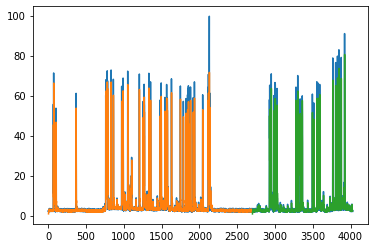

In [50]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
